In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import numpy as np
import os
from scipy import linalg
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
from torchvision.transforms import Resize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_shape):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.init_size = img_shape[1] // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_shape[0], 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, num_classes, img_shape):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(num_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.validity_layer = nn.Linear(512, 1)
        self.label_layer = nn.Linear(512, num_classes)

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        d_out = self.model(d_in)
        validity = self.validity_layer(d_out)
        label = self.label_layer(d_out)

        return validity, label
 
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

def get_features(model, images, batch_size=64):
    features = []
    for i in range(0, images.size(0), batch_size):
        batch = images[i:i+batch_size].cuda()
        with torch.no_grad():
            pred = model(batch)
        features.append(pred.cpu())
    features = torch.cat(features, dim=0)
    return features

def calculate_fid_with_features(real_features, gen_features):
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = gen_features.mean(axis=0), np.cov(gen_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Function to calculate inception activations
def get_inception_activations(images, inception_model, batch_size=16):
    # Process images in smaller batches to reduce memory usage
    activations = []
    for i in range(0, images.size(0), batch_size):
        batch = images[i:i + batch_size]
        batch_resized = torch.stack([Resize((299, 299))(image) for image in batch])
        with torch.no_grad():
            pred = inception_model(batch_resized.to(device))
            activations.append(pred.cpu())
    activations = torch.cat(activations, dim=0)
    return activations.numpy()

def inception_preprocess(images):
    preprocess = transforms.Compose([
        transforms.Resize(299),  # Resize to the size expected by Inception v3
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for Inception v3
    ])
    return torch.stack([preprocess(image) for image in images])

def generate_images(generator, num_images, latent_dim, num_classes, device):
    # Generate random latent vectors
    z = torch.randn(num_images, latent_dim, device=device)

    # Generate random labels (if your GAN is conditional)
    labels = torch.randint(0, num_classes, (num_images,), device=device)

    # Generate images
    with torch.no_grad():
        generator.eval()  # Set the generator to evaluation mode
        gen_images = generator(z, labels)
        generator.train()  # Set it back to train mode

    # Normalize the generated images (this should match the normalization used for real images)
    preprocess = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    gen_images = torch.stack([preprocess(image) for image in gen_images])

    return gen_images

In [17]:
transform = transforms.Compose([
    # transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

Files already downloaded and verified


In [18]:
# Hyperparameters
num_epochs = 300
latent_dim = 128  # Size of the latent space (noise vector)
num_classes = 10  # CIFAR-10 has 10 classes
batch_size = 128
img_shape = (3, 32, 32)  # Adjust if you used a different image size

# Loss functions
adversarial_loss = nn.BCEWithLogitsLoss()
auxiliary_loss = nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator(latent_dim, num_classes, img_shape).apply(weights_init_normal).cuda()
discriminator = Discriminator(num_classes, img_shape).apply(weights_init_normal).cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss()
aux_criterion = nn.CrossEntropyLoss()

inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model = inception_model.cuda()
inception_model.eval()
# Training Loop
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):

        batch_size = imgs.shape[0]
        valid = torch.ones(batch_size, 1).cuda()
        fake = torch.zeros(batch_size, 1).cuda()

        # Configure input
        real_imgs = imgs.cuda()
        labels = labels.cuda()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = torch.randn(batch_size, latent_dim).cuda()
        gen_labels = torch.randint(0, num_classes, (batch_size,)).cuda()
        
        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, real_aux = discriminator(real_imgs, labels)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")
        
        # Save Images every batch (or less frequently)
        # batches_done = epoch * len(train_loader) + i

        if epoch % 50 == 0:
            save_image(gen_imgs.data[:25], f"{epoch}.png", nrow=5, normalize=True)

        if epoch % 1 == 0:
            # Generate a batch of images
            real_images, _ = next(iter(train_loader))
            real_images = inception_preprocess(real_images.to(device))
            num_images = 64
            gen_images = generate_images(generator, num_images, latent_dim, num_classes, device)

            real_features = get_features(inception_model, real_images)
            gen_features = get_features(inception_model, gen_images)
            fid_value = calculate_fid_with_features(real_features.numpy(), gen_features.numpy())
            print(f'FID at batch {batches_done}: {fid_value}')

torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


c:\Users\zachu\.conda\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zachu\.conda\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Epoch 0/300] [Batch 0/391] [D loss: 1.4993987083435059] [G loss: 2.9962966442108154]


RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

In [ ]:
# Hyperparameters
num_epochs = 300
latent_dim = 128  # Size of the latent space (noise vector)
num_classes = 10  # CIFAR-10 has 10 classes
batch_size = 128
img_shape = (3, 32, 32)  # Adjust if you used a different image size

generator = Generator(latent_dim, num_classes, img_shape).cuda()
discriminator = Discriminator(num_classes, img_shape).cuda()

generator.load_state_dict(torch.load('generator.pth'))
discriminator.load_state_dict(torch.load('discriminator.pth'))

generator.eval()
discriminator.eval()

Discriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=3082, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): Dropout(p=0.4, inplace=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (validity_layer): Linear(in_features=512, out_features=1, bias=True)
  (label_layer): Linear(in_features=512, out_features=10, bias=True)
)

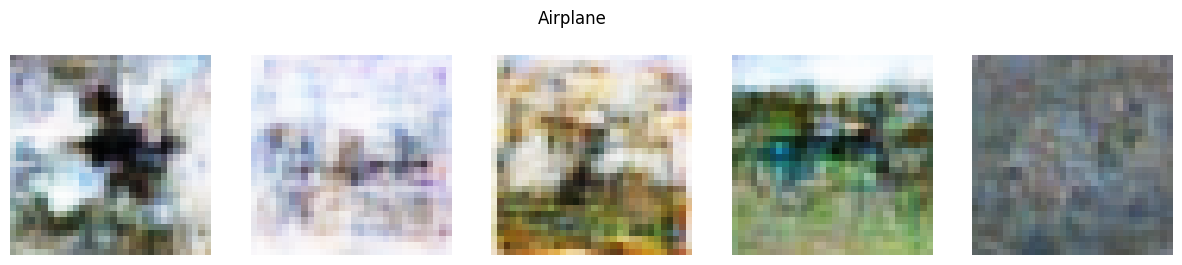

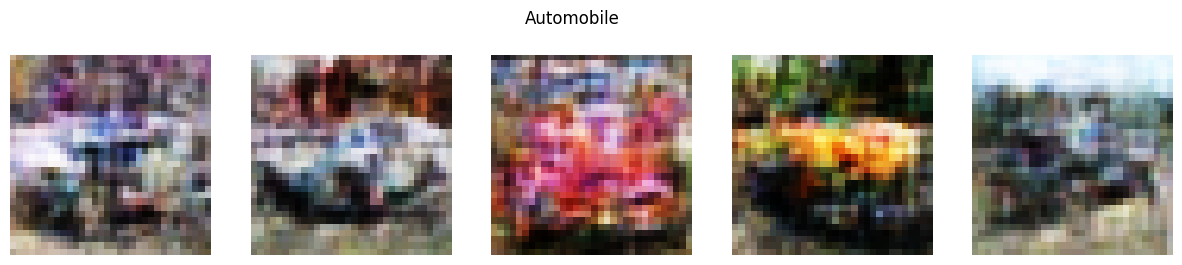

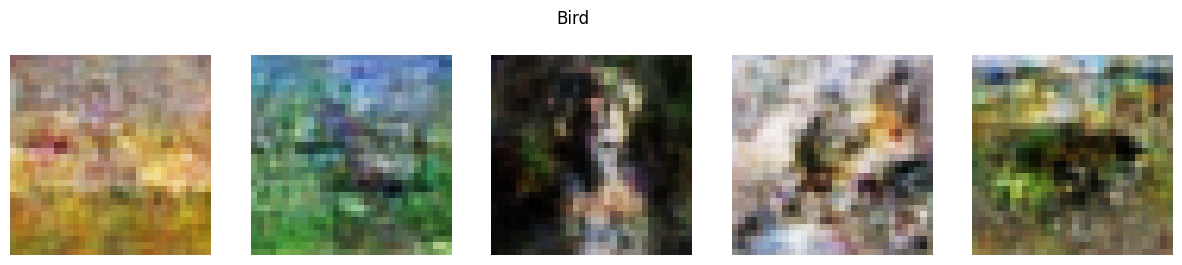

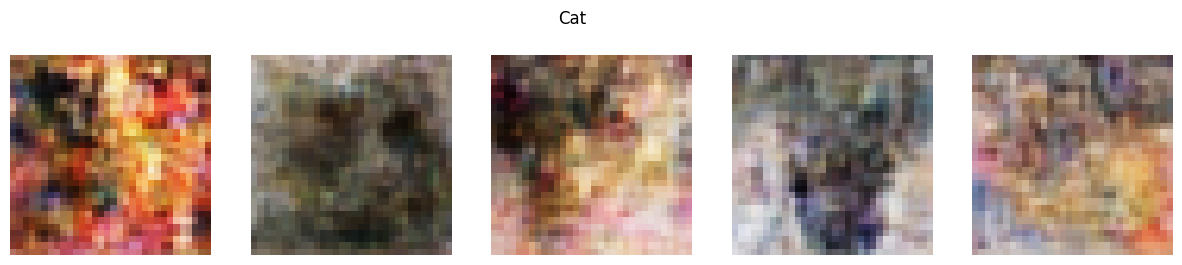

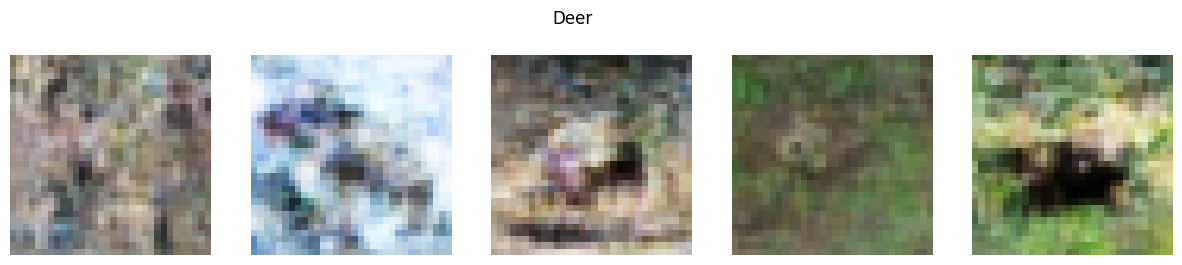

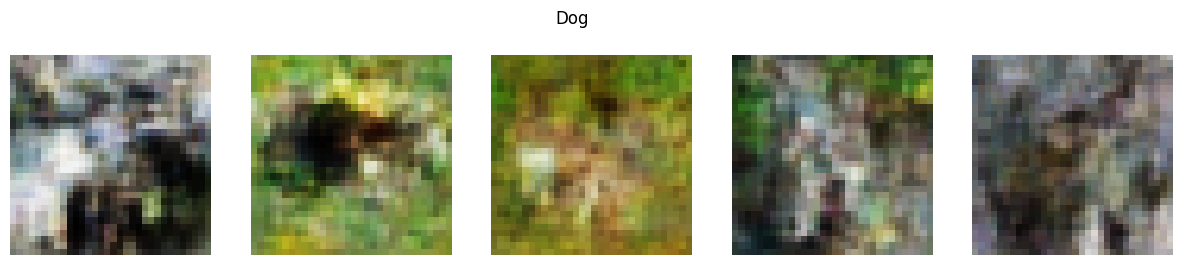

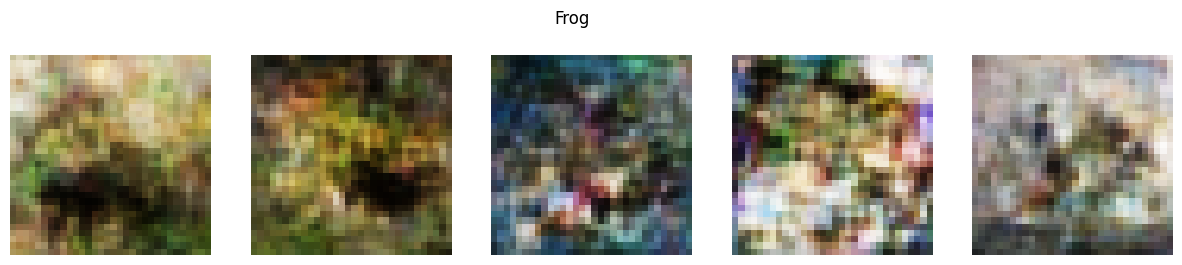

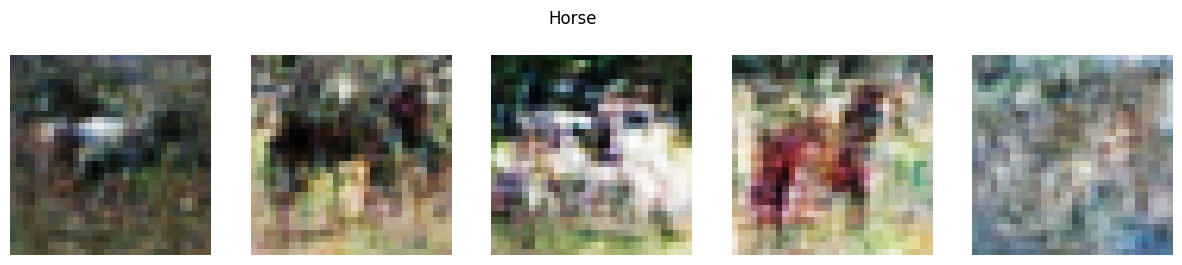

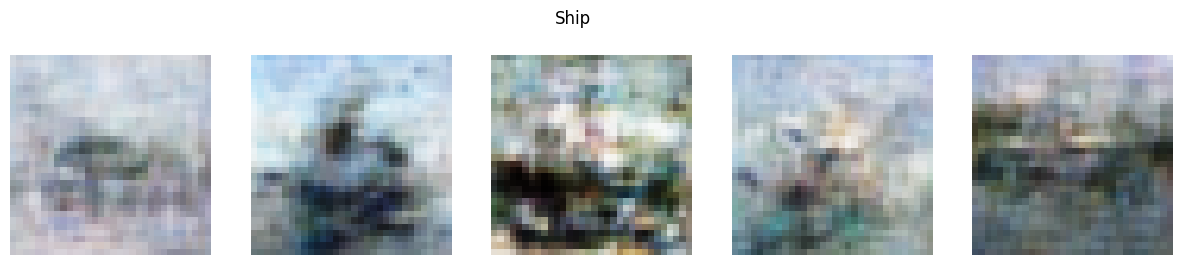

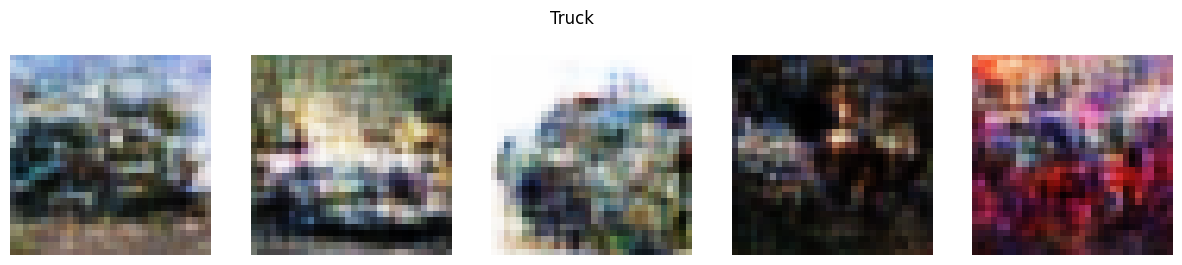

In [ ]:
import matplotlib.pyplot as plt
label_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Generate and display images
for i in range(10):
    z = torch.randn(5, latent_dim).cuda()
    labels = torch.full((5,), i, dtype=torch.long).cuda()  # Generate 5 images for class 'i'
    gen_imgs = generator(z, labels)

    # Convert images for display
    gen_imgs = (gen_imgs + 1) / 2  # Rescale to [0, 1]
    gen_imgs = gen_imgs.detach().cpu()

    # Display images
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(label_names[i])

    for j in range(5):
        axs[j].imshow(gen_imgs[j].permute(1, 2, 0))
        axs[j].axis('off')

    plt.show()